# Modeling and Simulation in Python

Chapter 3: Explain

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

## Reading data



In [2]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

From here on, we will work in units of billions.

In [3]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [4]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

### Now with system objects

We can rewrite the code from the previous section using system objects.

In [5]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

p_0 = census[t_0]
p_end = census[t_end]
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time

0.07229017472307693

Here's the system object.

In [6]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

,value
t_0,1950.000000
t_end,2015.000000
p_0,2.557629
annual_growth,0.072290


And we can encapsulate the code tha runs the model in a function that stores the resulting Series as a new system variable.

In [7]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end-1):
        results[t+1] = results[t] + system.annual_growth
    
    return results

We can also encapsulate the code that plots the results.

In [8]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

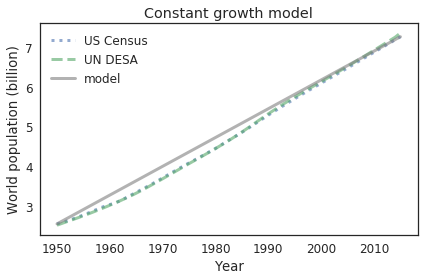

In [9]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

**Exercise:** The constant growth model doesn't make a lot of sense, because it seems like the number of deaths and births should depend on the size of the population.  As a small improvement, let's write a version of `run_simulation1` where the number of deaths is proportional to the size of the population, but the number of births is constant.  This model doesn't make a lot of sense, either, but it's a good exercise.

Write a function called `run_simulation1b` that implements a model where the number of births is constant, but the number of deaths is proportional to the current size of the population.  Set the death rate to `0.01`, which means that 1% of the population dies each year; then choose the number of annual births to make the model fit the data as well as you can.

Hint: It probably won't fit very well.

In [10]:
# Solution

def run_simulation1b(system):
    """Runs a model with proportional birth and constant death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end-1):
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + system.annual_births - deaths
        
    return results

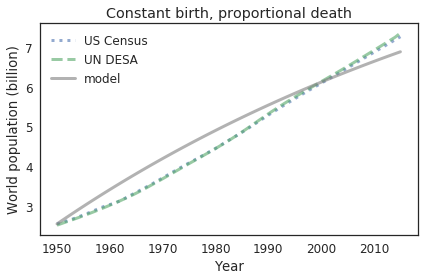

In [11]:
# Solution

system.death_rate = 0.01
system.annual_births = annual_growth * 1.6

results = run_simulation1b(system)
plot_results(census, un, results, 'Constant birth, proportional death')

## Proportional death, proportional birth

Now let's get to a more realistic model where the number of births and deaths is proportional to the current population.

In [12]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end-1):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

I kept the death rate at 1% and chose the birth rate to fit the data.

In [13]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

Saving figure to file chap03-fig03.pdf


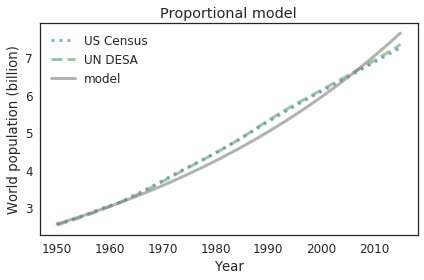

In [14]:
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
savefig('chap03-fig03.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

## Exercises

**Exercise:** In this implementation, we compute the number of deaths and births separately, but since they are both proportional to the current population, we can combine them.

Write a function called `run_simulation2b` that implements a model with a single parameter, `alpha`, that represents the net growth rate, which is the difference between the birth and death rates.  For example, if `alpha=0.01`, the population should grow by 1% per year.

Choose the value of `alpha` that fits the data best.

In [15]:
# Solution

def run_simulation2b(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end-1):
        net_growth = system.alpha * results[t]
        results[t+1] = results[t] + net_growth
        
    return results

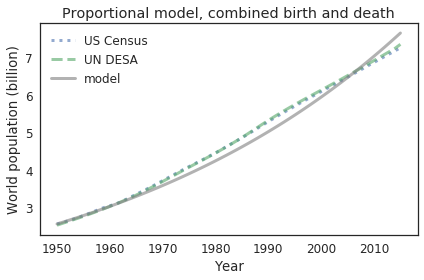

In [16]:
# Solution

system.alpha = 0.017

results = run_simulation2b(system)
plot_results(census, un, results, 'Proportional model, combined birth and death')